# P4 Advanced Lane Lines: Final Pipeline
### Outline:
    0. Imports and Presets
    1. Read Camera Calibration Data
    2. Pipeline Functions
    3. Test Pipeline
    4. Complete Image Pipeline
    5. Create Video Output
## 0. Imports and Presets

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

# Used for converting pixel to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Parameters for detection window
margin = 100
minpix=50
nwindows=10

# Coordinates and warp transformation matrices
src = np.float32(((602,445), (200,720), (1130,720), (682,445)))
dst = np.float32(((320,0), (320,720), (960,720), (960,0)))
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

font = cv2.FONT_HERSHEY_SIMPLEX

## 1. Read Camera Calibration Data

In [2]:
# Load mtx and dist from camera calibration pickle file
with open("camera_cal/camera_cal_pickle.p", mode='rb') as f:
    data = pickle.load(f)
    mtx = data['mtx']
    dist = data['dist']

## 2. Pipeline Functions

In [3]:
# Function to undistort image based on camera calibration
def undistort_image (img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# CIELAB color space transformation based on channel and threshold
def lab_thresh(img, chan=2, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_chan = lab[:,:,chan]
    binary_output = np.zeros_like(lab_chan)
    binary_output[(lab_chan > thresh[0]) & (lab_chan <= thresh[1])] = 1
    return binary_output

# Creates binary image for lane detection
def final_binary (undist):
    binary_output = np.zeros_like(undist[:,:,0])
    lab1 = lab_thresh(undist, chan=2, thresh=(150, 255))
    lab2 = lab_thresh(undist, chan=0, thresh=(215, 255))
    binary_output[(lab1==1) | (lab2==1)] = 1
    return binary_output

def warp_image (undist, M):
    img_size = (undist.shape[1], undist.shape[0])
    return cv2.warpPerspective(undist, M, img_size)

# Sliding window search to find lane lines
# Assuming you have created a warped binary image called "binary_warped"
def window_search(binary_warped, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit

# Used with existing best fit lines and new binary_warped image
def fit_based_search (binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

# Returns curvature of left and right lanes in meters
def real_lane_curvature(left_fit, right_fit, ploty):
    # Define conversions in x and y from pixels space to meters
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

# Returns the car's offset from lane center based on best fit lines
# Positive offset means car's position is right of center
def car_offset (undist, left_fit, right_fit):
    y_max = undist.shape[0]
    leftx_y_max = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_y_max = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    lane_center = (leftx_y_max + rightx_y_max) / 2
    offset = undist.shape[1]/2 - lane_center
    return offset * xm_per_pix

# Draw lane on undistorted image
def draw_lane(undist, binary_warped, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_warped[0].shape[0]-1, binary_warped[0].shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(binary_warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    fill_image = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    lane_image = cv2.warpPerspective(binary_warped, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    drawn_fill = cv2.addWeighted(undist, 1, fill_image, 0.3, 0)
    drawn_fill[lane_image[:,:,0] == 255, 1] = 0
    drawn_fill[lane_image[:,:,0] == 255, 2] = 0
    drawn_fill[lane_image[:,:,2] == 255, 0] = 0
    drawn_fill[lane_image[:,:,2] == 255, 1] = 0
    drawn_lanes = cv2.addWeighted(drawn_fill, 1, lane_image, 1, 0)
    
    # Print lane curvatures and offset on image
    left_curve, right_curve = real_lane_curvature(left_fit, right_fit, ploty)
    offset = car_offset(undist, left_fit, right_fit)
    left_curve_text = 'left lane curve (m): ' + str(left_curve)
    right_curve_text = 'right lane curve (m): ' + str(right_curve)
    offset_text = 'center offset (m): ' + str(offset)
    cv2.putText(drawn_lanes, left_curve_text,(20,60), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(drawn_lanes, right_curve_text,(20,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result = cv2.putText(drawn_lanes, offset_text,(20,140), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return drawn_lanes

## 3. Test Pipeline

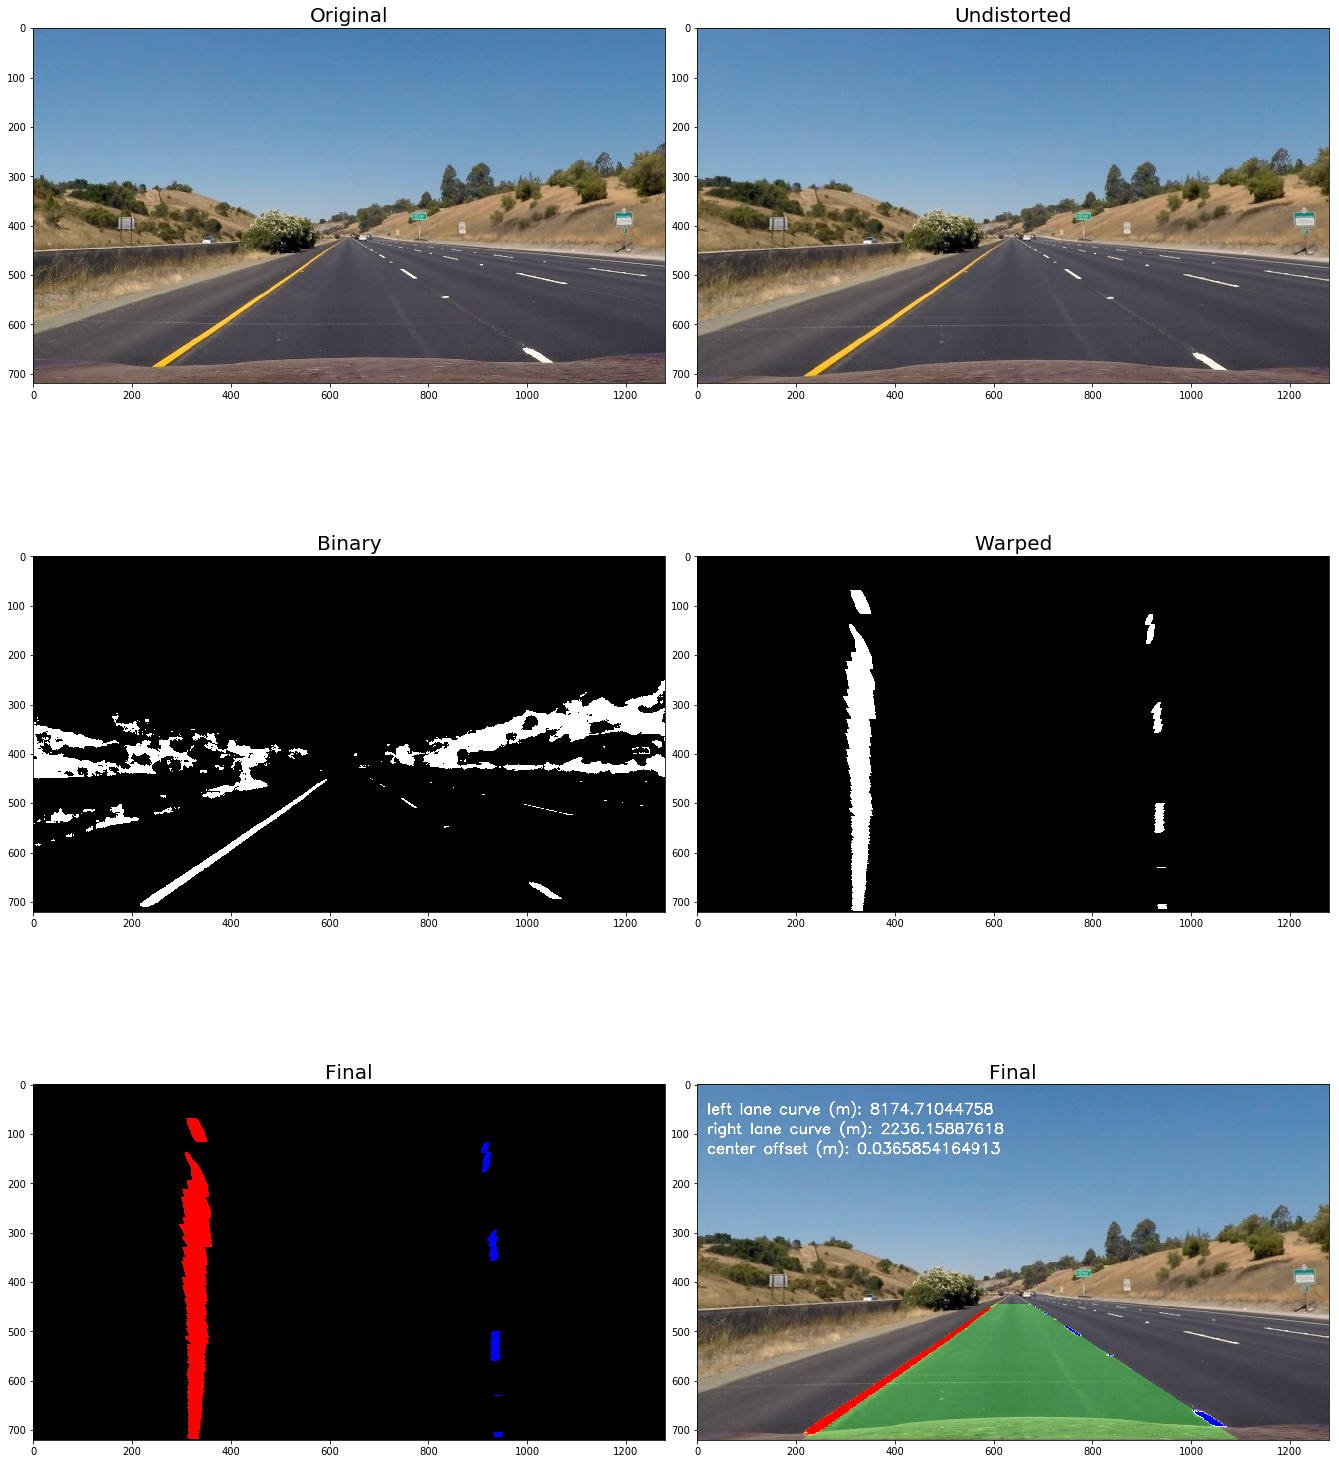

In [4]:
test_image = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort_image(test_image)
binary = final_binary(undist)
binary_warped = warp_image(binary, M)
lanes_warped, left_fit, right_fit = window_search(binary_warped)
final_image = draw_lane(undist, lanes_warped, left_fit, right_fit, Minv)

# Plot the result for x gradient
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 24))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=20)

ax3.imshow(binary, cmap='gray')
ax3.set_title('Binary', fontsize=20)
ax4.imshow(binary_warped, cmap='gray')
ax4.set_title('Warped', fontsize=20)

ax5.imshow(lanes_warped)
ax5.set_title('Final', fontsize=20)
#ax6.set_visible(False)
ax6.imshow(final_image)
ax6.set_title('Final', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

## 4. Complete Image Pipeline

In [5]:
def pipeline(image):
    undist = undistort_image(image)
    binary = final_binary(undist)
    binary_warped = warp_image(binary, M)
    lanes_warped, left_fit, right_fit = window_search(binary_warped)
    final_image = draw_lane(undist, lanes_warped, left_fit, right_fit, Minv)
    return final_image

## 5. Create Output Video

In [6]:
input_video = 'project_video.mp4'
output_video = 'output_video.mp4'
clip = VideoFileClip(input_video)
#clip = VideoFileClip(input_video).subclip(0,3)
processed = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [02:14<00:00,  9.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 3min 52s, sys: 19.7 s, total: 4min 12s
Wall time: 2min 15s
